In [1]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

from src.benchmarks import *
from src.utils_data import prepare_data, seas_dict
from src.utils_evaluation import *
from src.utils_visualization import plot_grid_series, plot_distributions


In [2]:
def models_metrics_filter(h, freq, models_filter, metrics_filter):
    # Parse time series arguments
    seasonality = seas_dict[freq]['seasonality']
    
    models = {'Naive':  Naive(h=h),
              'SeasonalNaive': SeasonalNaive(h=h, seasonality=seasonality),
              'Naive2': Naive2(h=h, seasonality=seasonality),
              'RandomWalkDrift': RandomWalkDrift(h=h),
              'Croston': Croston(kind='classic'),
              'MovingAverage': MovingAverage(h=h, n_obs=20),
              'SeasonalMovingAverage': SeasonalMovingAverage(h=h, n_seasons=2,
                                                             seasonality=seasonality)}
    
    metrics = {'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 
               'MASE': mase, 'RMSSE': rmsse}
    
    # Filtered models and metrics
    models = {model_name: models[model_name] for model_name in models_filter}
    metrics = {metric_name: metrics[metric_name] for metric_name in metrics_filter}
    
    return models, metrics

def uids_filter(y_df, size=8):
    uids = y_df.index.get_level_values('unique_id').unique()
    uids_sample = np.random.choice(uids, size=8)
    return uids_sample

def ml_pipeline(directory, h, freq, models_filter, metrics_filter):
    # Set random seeds
    np.random.seed(1)

    # Filter models and metrics
    models, metrics = models_metrics_filter(h, freq,
                                            models_filter, metrics_filter)


    # Parse arguments
    seasonality = seas_dict[freq]['seasonality']
    
    # Read data
    X_train_df, y_train_df, X_test_df, y_test_df = prepare_data(directory, h)

    # Pre sort dataframes for efficiency
    X_train_df = X_train_df.set_index(['unique_id', 'ds']).sort_index()
    y_train_df = y_train_df.set_index(['unique_id', 'ds']).sort_index()
    X_test_df = X_test_df.set_index(['unique_id', 'ds']).sort_index()
    y_test_df = y_test_df.set_index(['unique_id', 'ds']).sort_index()
    
    # Fit and predict benchmark models
    preds = [y_test_df.y]
    print("\n Fitting models")
    for model_name, model in models.items():
        print(model_name)
        
        panel_model = PanelModel(model)
        panel_model.fit(X_train_df, y_train_df)
        mod_preds = panel_model.predict(X_test_df)
        
        mod_preds.name = model_name
        preds.append(mod_preds)
    
    # Merge y_df for visualization purpose
    y_hat_df = pd.concat(preds, axis=1)
    y_train_df['split'] = 'train'
    y_hat_df['split'] = 'test'
    y_df = y_train_df.append(y_hat_df, sort=False)
    
    # Evaluation Metrics
    y_hat_df = y_hat_df.drop(['split', 'y'], axis=1)
    evaluations = compute_evaluations(y_test=y_test_df, y_hat=y_hat_df, 
                                      y_train=y_train_df, metrics=metrics, 
                                      seasonality=seasonality)

    # Compute SMAPE residuals
    residuals_dict = {}
    for col in y_hat_df.columns:
        residuals_dict[col] = evaluate_panel(y_test=y_test_df, y_hat=y_hat_df[col],
                                             y_train=y_train_df, metric=smape,
                                             seasonality=seasonality)
    plot_distributions(residuals_dict)

    # Pipeline results
    plot_grid(y_df, models, h)
    evaluations.to_csv('./results/metrics.csv', index=False)

    return y_df, models

def plot_grid(y_df, models, h):
    uids_sample = uids_filter(y_df, size=8)
    plot_grid_series(y_df, uids_sample, models, plt_h=(h*5))

def plot_residuals(residuals_dict):
    pass


directory ./data/m4/Yearly.csv

 Fitting models
Naive
SeasonalNaive
Naive2
RandomWalkDrift
Croston
MovingAverage
SeasonalMovingAverage

 Evaluating models
RMSE
MAPE
SMAPE
MASE
RMSSE


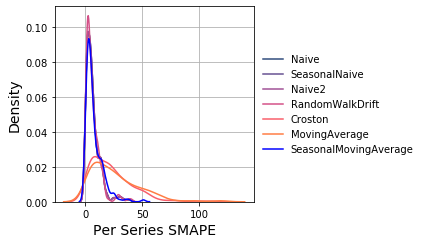

In [3]:
# directory = './data/m4/Hourly.csv'
# freq = 'Hourly'
# h = 24

# directory = './data/m4/Daily.csv'
# freq = 'Daily'
# h = 14

# directory = './data/m4/Weekly.csv'
# freq = 'Weekly'
# h = 4

# directory = './data/m4/Monthly.csv'
# freq = 'Monthly'
# h = 3

# directory = './data/m4/Quarterly.csv'
# freq = 'Quarterly'
# h = 1

directory = './data/m4/Yearly.csv'
freq = 'Yearly'
h = 2

models_filter = ['Naive', 'SeasonalNaive', 'Naive2', 'RandomWalkDrift',
                 'Croston', 'MovingAverage', 'SeasonalMovingAverage']
metrics_filter = ['RMSE', 'MAPE', 'SMAPE', 'MASE', 'RMSSE']

y_df, models = ml_pipeline(directory, h, freq, models_filter, metrics_filter)